### The STV-FIS effort is funded by the NASA Decadal Survey Incubation program - **NNH21ZDA001N-DSI**

# SDAP Tomogram Visualization Endpoints

## IMPORTANT NOTE!

Deployment of these changes is still a work in progress and thus is not publicly available. If you wish to run this notebook, the code used came from the following:
- Nexus:
  - Repo: https://github.com/RKuttruff/incubator-sdap-nexus.git
  - Branch: STV-SDAP-viz
- Ingester:
  - Repo: https://github.com/RKuttruff/incubator-sdap-ingester.git
  - Branch: SDAP-469-3d-data
- Nexus:
  - Repo: https://github.com/RKuttruff/incubator-sdap-nexusproto.git
  - Branch: SDAP-469-3d-data

This notebook showcases some new vizualization capabilities built directly into SDAP for the purposes of visuzlizing SAR and LIDAR data. The following demo products were used:
- SAR: Work in progress geolocated product (not publicly availabe). Kings Canyon, CA
- LIDAR: Single sample from [this dataset](https://daac.ornl.gov/ABOVE/guides/ABoVE_LVIS_VegetationStructure.html). Saskatchewan, Canada

In [1]:
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
from datetime import datetime

def get(url, params):
    t = datetime.now()
    
    try:
        print('Waiting for response from SDAP...', end='')
        response = requests.get(url, params=params)
        td = datetime.now() - t
        response.raise_for_status()
        
        print(f' Done in {td}')
    except:
        print(f' Failed in {td}')
        print(response.text)
        raise
        
    return response

In [2]:
BASE_URL = 'http://localhost:8083'
NEXUS_URL = f'{BASE_URL}'

TOMOGRAM_ELEV_URL = f'{NEXUS_URL}/tomogram/elevation'
TOMOGRAM_LAT_URL = f'{NEXUS_URL}/tomogram/latitude'
TOMOGRAM_LON_URL = f'{NEXUS_URL}/tomogram/longitude'

LIDAR_URL = f'{NEXUS_URL}/stv/lidar'

In [3]:
TOMOGRAM_DS = 'Kings_Tomogram_Test_2-temp'
LIDAR_DS = 'LVIS_ABoVE'

Waiting for response from SDAP... Done in 0:00:53.408885


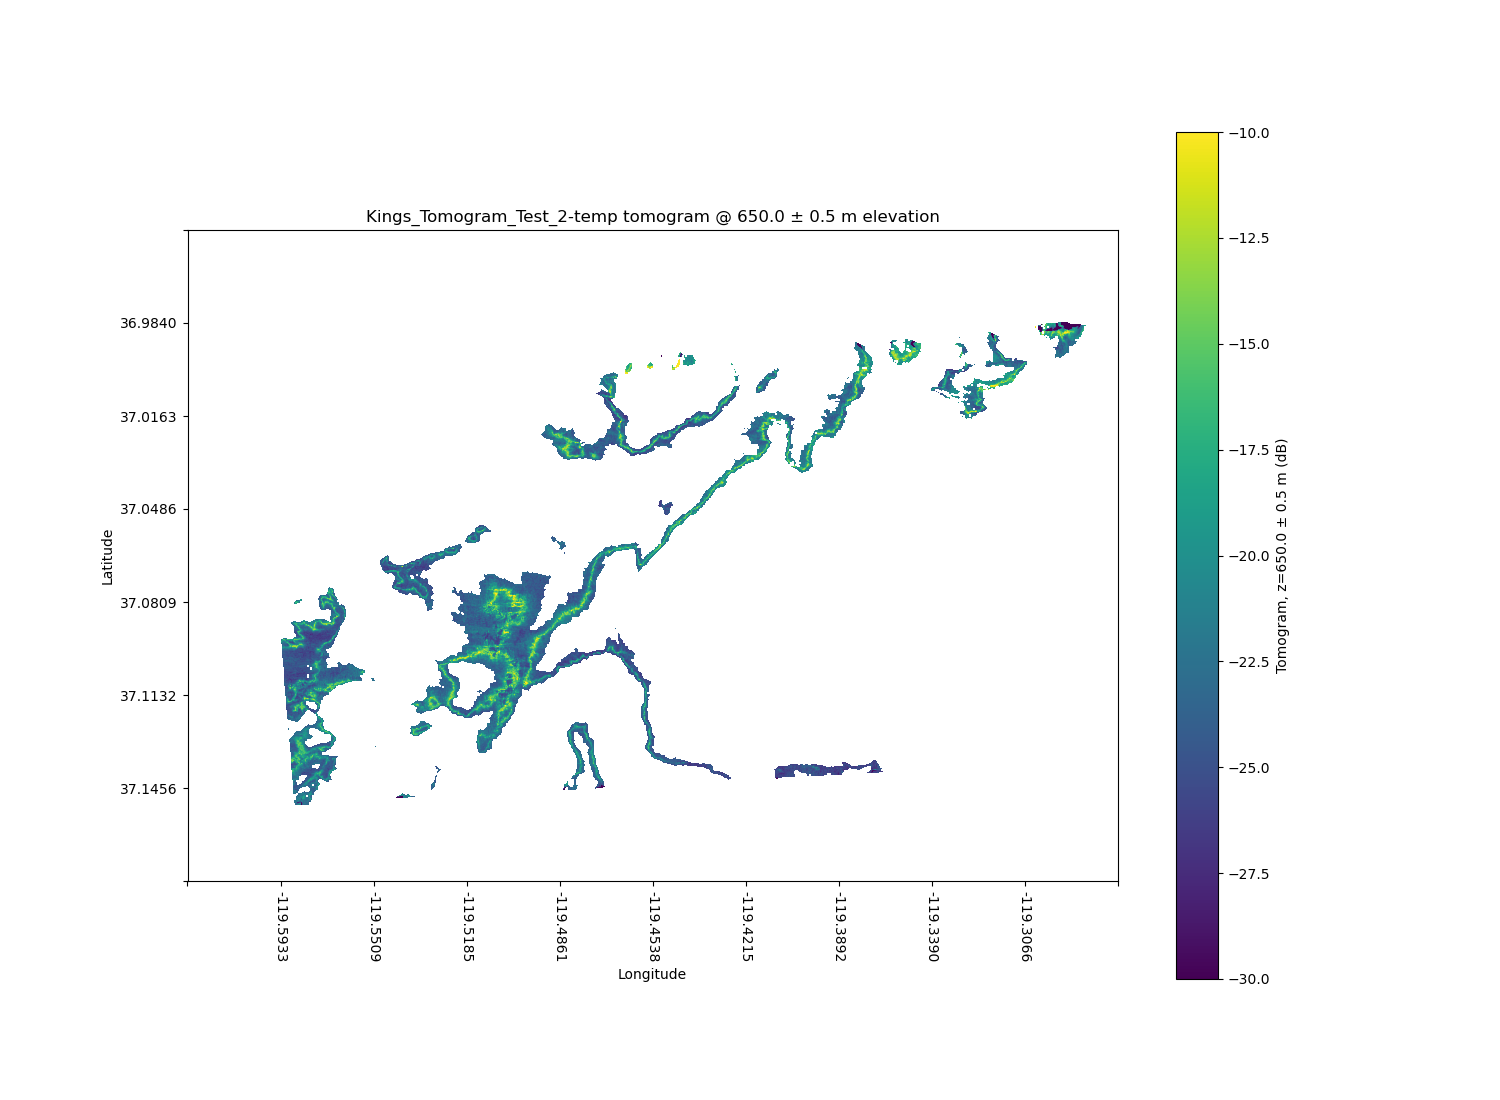

In [4]:
params = dict(
    ds=TOMOGRAM_DS,
    b='-120,36.8,-118,37.3',
    elevation=650,
    output='PNG'
)

response = get(TOMOGRAM_ELEV_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:30.731166


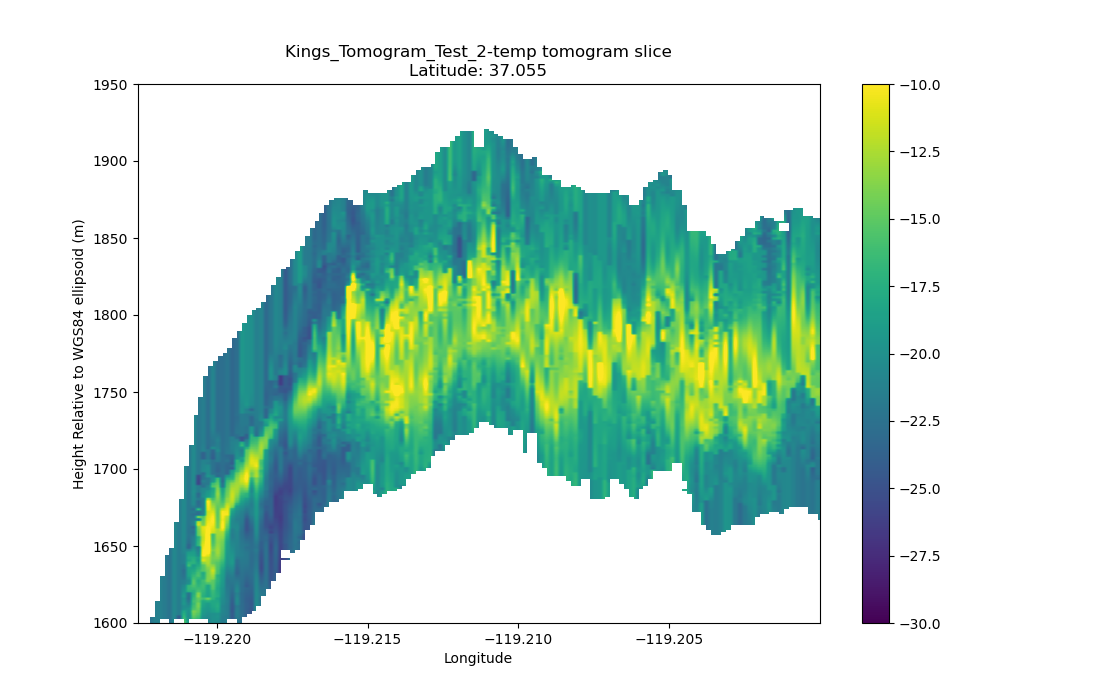

In [6]:
params = dict(
    ds=TOMOGRAM_DS,
    output='PNG',
    latitude=37.055,
    minLon=-119.24,
    maxLon=-119.2,
    minElevation=1600,
    maxElevation=1950,
    stride=1
)

response = get(TOMOGRAM_LAT_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:25.234284


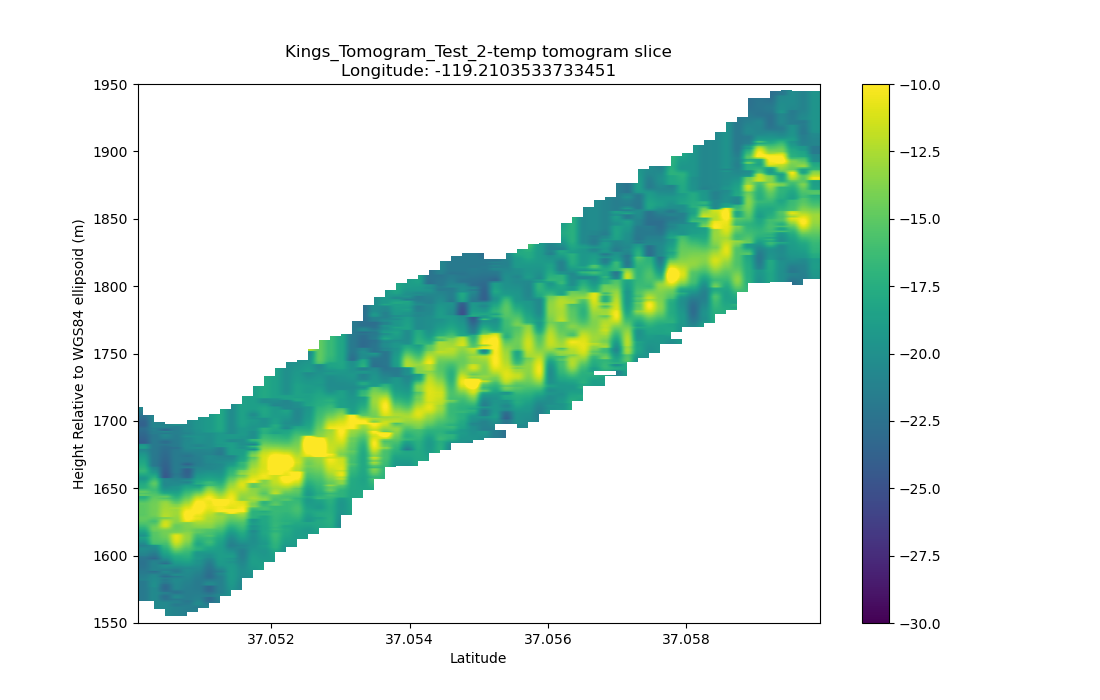

In [7]:
params = dict(
    ds=TOMOGRAM_DS,
    output='PNG',
    longitude=-119.2103533733451,
    minLat=37.05,
    maxLat=37.06,
    minElevation=1550,
    maxElevation=1950,
    stride=1
)

response = get(TOMOGRAM_LON_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

## LIDAR

The following cells will showcase SDAP's LIDAR endpoint (Still a WIP)

Waiting for response from SDAP... Done in 0:00:03.956614


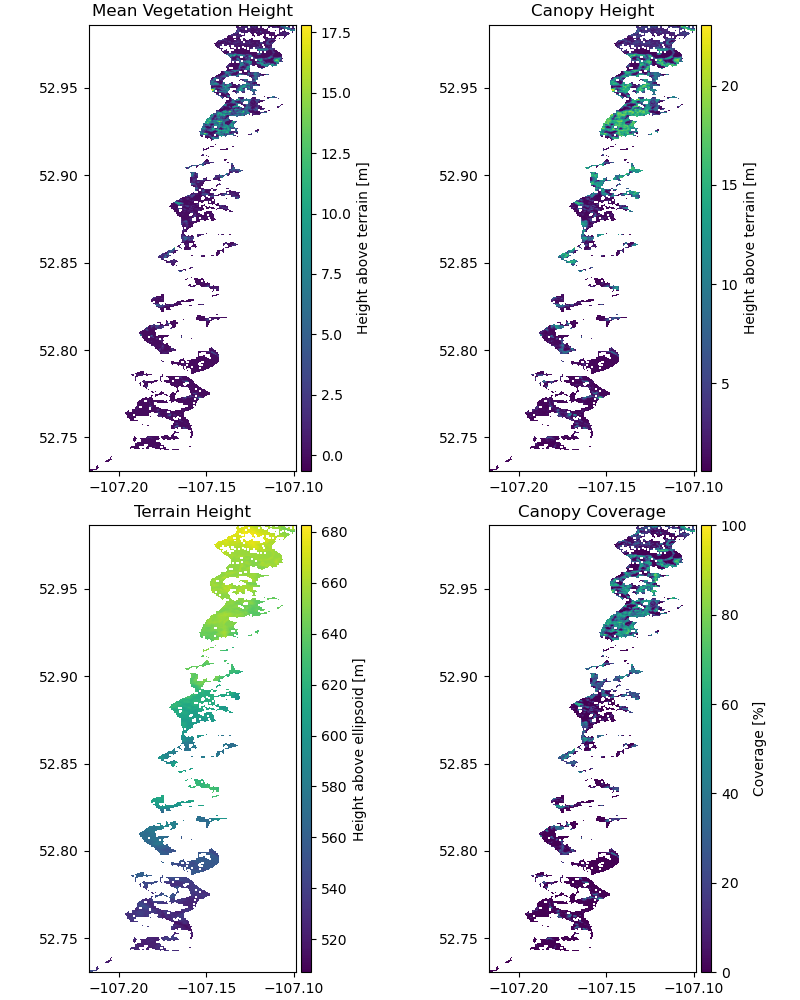

In [8]:
# Following params will just produce 2D plots of vegetation heights, terrain height, and canopy coverage

params = dict(
    ds='LVIS_ABoVE',
    b='-107.5,52.5,-106.5,53',
    startTime='2017-06-29T00:00:00Z',
    endTime='2017-06-29T00:00:00Z',
    output='PNG'
)

response = get(LIDAR_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:04.170748


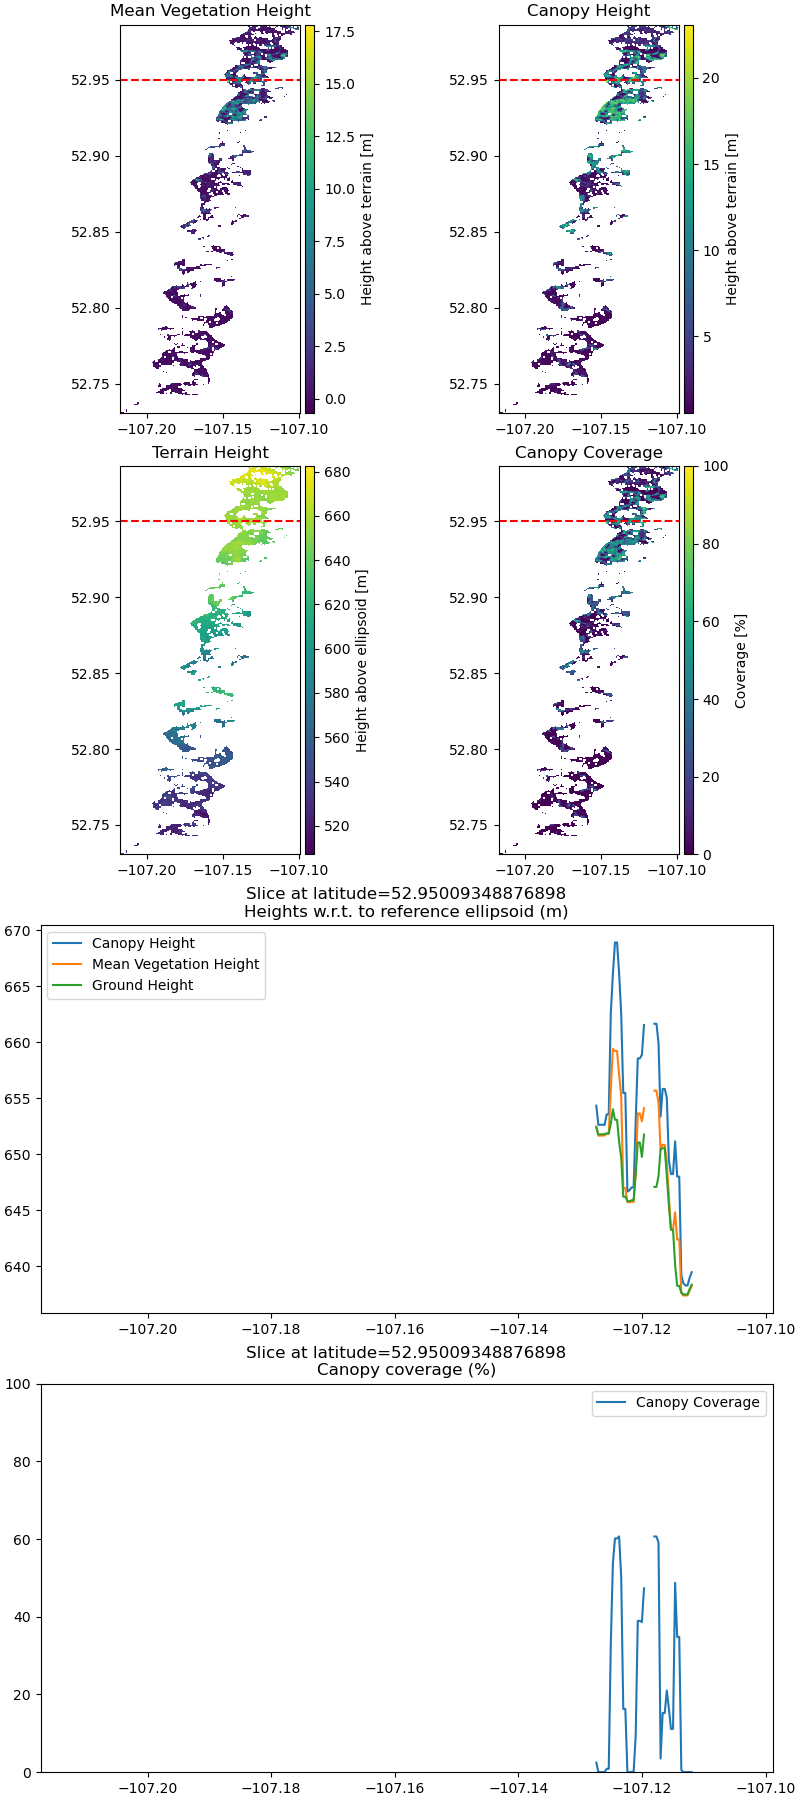

In [9]:
# Easily add 1D plots showing the values along a given latitude...

params = dict(
    ds='LVIS_ABoVE',
    b='-107.5,52.5,-106.5,53',
    startTime='2017-06-29T00:00:00Z',
    endTime='2017-06-29T00:00:00Z',
    latSlice=52.95,
    output='PNG'
)

response = get(LIDAR_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:04.221388


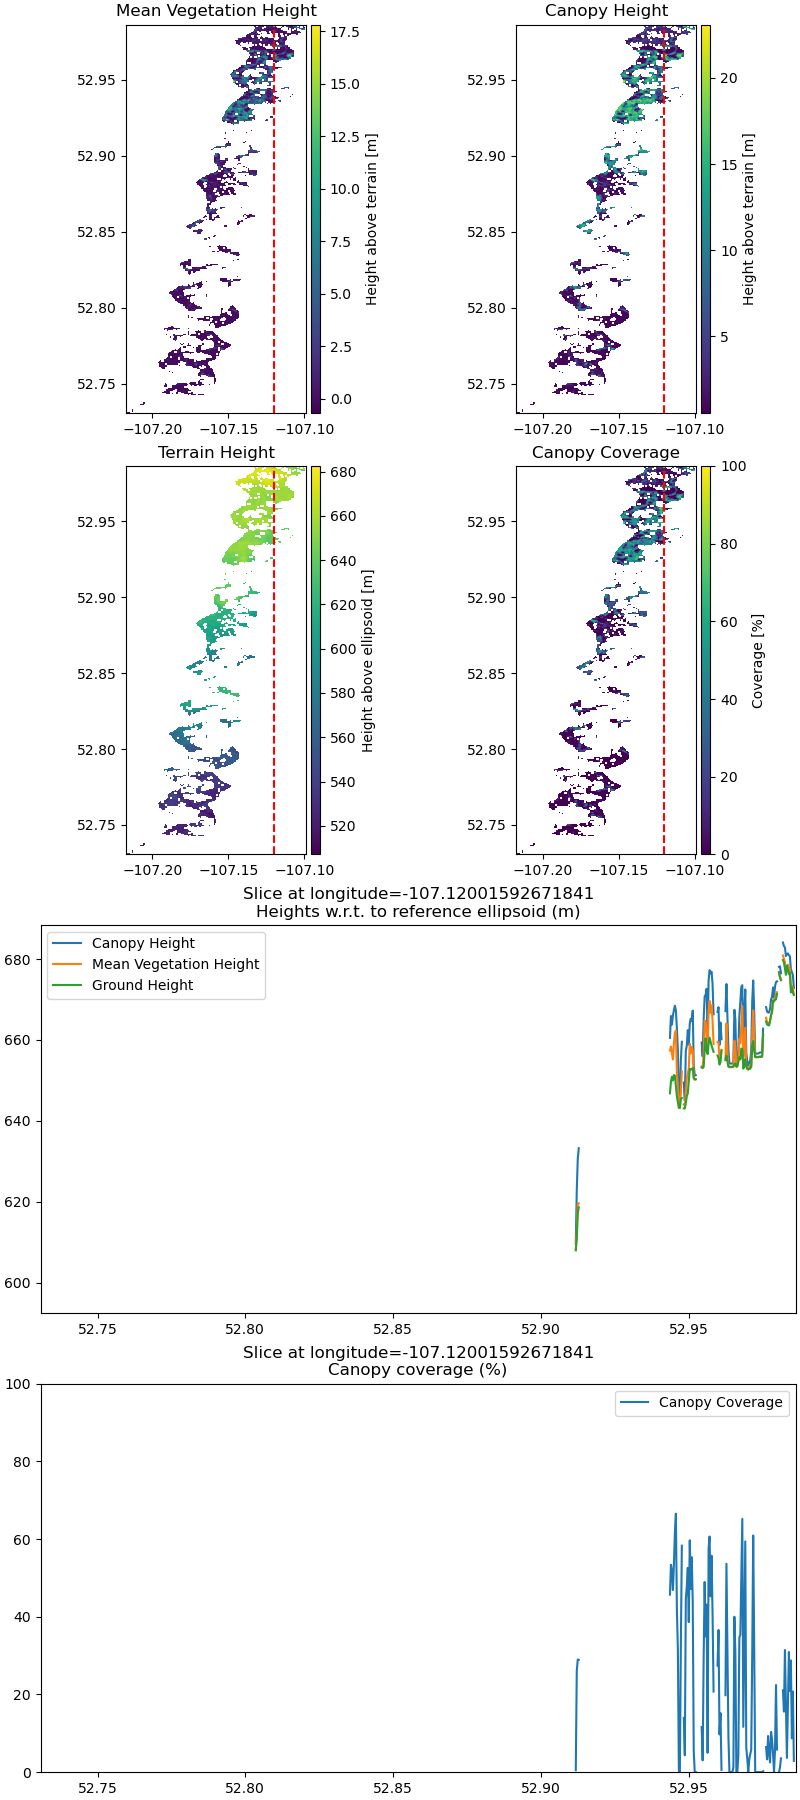

In [10]:
# ... or longitude ...

params = dict(
    ds='LVIS_ABoVE',
    b='-107.5,52.5,-106.5,53',
    startTime='2017-06-29T00:00:00Z',
    endTime='2017-06-29T00:00:00Z',
    lonSlice=-107.12,
    output='PNG'
)

response = get(LIDAR_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:04.310860


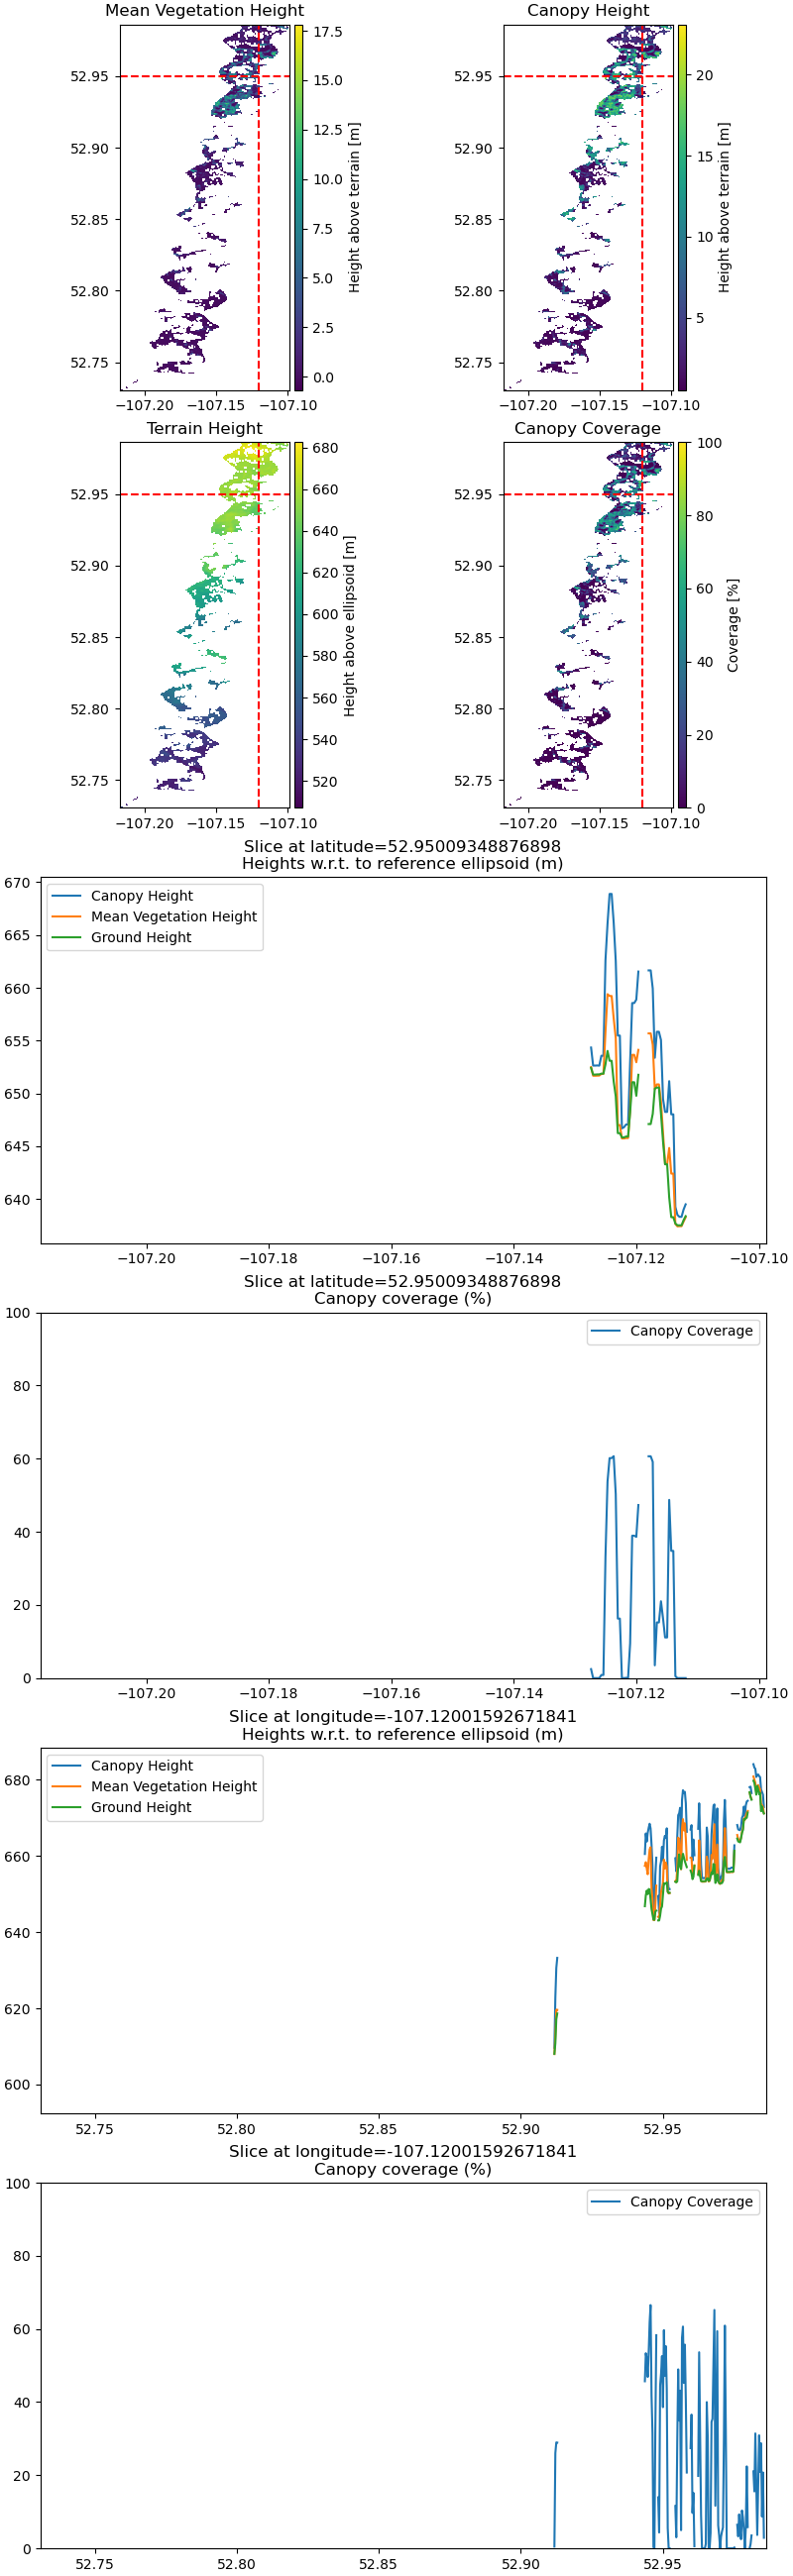

In [11]:
# ... or both at the same time!

params = dict(
    ds='LVIS_ABoVE',
    b='-107.5,52.5,-106.5,53',
    startTime='2017-06-29T00:00:00Z',
    endTime='2017-06-29T00:00:00Z',
    latSlice=52.95,
    lonSlice=-107.12,
    output='PNG'
)

response = get(LIDAR_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)